In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import scipy.stats
import sklearn.feature_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.tree
import collections
%matplotlib inline

Read in the metadata specifying column names and admissible values for each column:

In [2]:
with open('us_census_full/census_income_metadata.txt') as f:
    metadata = f.readlines()
metadata = [line.strip() for line in metadata]
# Discard comment and empty lines
metadata = [line for line in metadata if len(line) > 0 and line[0] != '|']
# Lines containing colon specify column name and admissible values
metadata = [line for line in metadata if ':' in line]
# Strip trailing full stops
metadata = [line[:-1] if line[-1] == '.' else line for line in metadata]
# Separate into respective lists of keys and values
keys, values = zip(*[tuple(line.split(':')) for line in metadata])
# Create individual lists of admissible values
values = [v.split(',') for v in values]
# Strip whitespace
values = [[w.strip() for w in v] for v in values]
# Create dict with ordering imposed on keys (i.e. the column names)
metadata = collections.OrderedDict(zip(keys, values))

Print number of column and column names:

In [3]:
print("Number of columns: %d" % len(metadata))
print("Column names: \n%s" % pd.Series(metadata.keys()))

Number of columns: 41
Column names: 
0                                            age
1                                class of worker
2                       detailed industry recode
3                     detailed occupation recode
4                                      education
5                                  wage per hour
6                     enroll in edu inst last wk
7                                   marital stat
8                            major industry code
9                          major occupation code
10                                          race
11                               hispanic origin
12                                           sex
13                       member of a labor union
14                       reason for unemployment
15             full or part time employment stat
16                                 capital gains
17                                capital losses
18                         dividends from stocks
19                              

The column names as defined do not include the binary outcome variable. Amend accordingly:

In [4]:
metadata['salary'] = ['- 50000', '50000+']

Print assembled meta-data:

In [5]:
metadata

OrderedDict([('age', ['continuous']),
             ('class of worker',
              ['Not in universe',
               'Federal government',
               'Local government',
               'Never worked',
               'Private',
               'Self-employed-incorporated',
               'Self-employed-not incorporated',
               'State government',
               'Without pay']),
             ('detailed industry recode',
              ['0',
               '40',
               '44',
               '2',
               '43',
               '47',
               '48',
               '1',
               '11',
               '19',
               '24',
               '25',
               '32',
               '33',
               '34',
               '35',
               '36',
               '37',
               '38',
               '39',
               '4',
               '42',
               '45',
               '5',
               '15',
               '16',
               '22',
 

Read in the data, setting the column names:

In [6]:
census_train = pd.read_csv('us_census_full/census_income_learn.csv', index_col=None, header=None, names=metadata.keys())
census_test = pd.read_csv('us_census_full/census_income_test.csv', index_col=None, header=None, names=metadata.keys())

Initial spot-check of training data:

In [8]:
census_train.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,salary
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


Summarise numerical variables:

In [9]:
census_train.describe()

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,15.352320,11.306556,55.426908,434.71899,37.313788,197.529533,1740.380269,1.956180,0.175438,1.514833,23.174897,94.499672
std,22.310895,18.067129,14.454204,274.896454,4697.53128,271.896428,1984.163658,993.768156,2.365126,0.553694,0.851473,24.411488,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1061.615000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1618.310000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.00000,0.000000,0.000000,2188.610000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.00000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


Initial data cleaning based on preceding spot check:

In [10]:
# Strip whitespace around strings
f = lambda v: v.strip() if isinstance(v, str) else v
census_train = census_train.applymap(f)
census_test = census_test.applymap(f)

# Remove trailing full stop in salary column
census_train['salary'] = census_train['salary'].str.replace('.','')
census_test['salary'] = census_test['salary'].str.replace('.','')

It appears reasonable to treat columns 'own business or self employed', 'veterans benefits', 'year' as categorical data, since according to the meta-data there are few associated unique values, respectively. With admissible values already represented using strings in metadata, convert to strings. Also treat 'detailed industry recode', 'detailed occupation recode' as categorical data. NB: 'num persons worked for employer' we consider ordinal.

In [11]:
f = lambda v: str(v)
for col in ('own business or self employed', 'veterans benefits', 'year', 'detailed industry recode', 'detailed occupation recode'):
    census_train[col] = census_train[col].apply(f)
    census_test[col] = census_test[col].apply(f)

Verify that no inadmissible values are contained in data:

In [12]:
for col in metadata:
    for df, name in zip((census_train, census_train), ('training data', 'testing data')):
        if metadata[col] != ['continuous']:
            inadmissible = np.setdiff1d(df[col].unique(), metadata[col])
            if len(inadmissible) > 0:
                print('Inadmissible values in %s, column [%s]: %s' % (name, col, inadmissible))

Inadmissible values in training data, column [state of previous residence]: ['?']
Inadmissible values in testing data, column [state of previous residence]: ['?']
Inadmissible values in training data, column [migration code-change in msa]: ['?']
Inadmissible values in testing data, column [migration code-change in msa]: ['?']
Inadmissible values in training data, column [migration code-change in reg]: ['?']
Inadmissible values in testing data, column [migration code-change in reg]: ['?']
Inadmissible values in training data, column [migration code-move within reg]: ['?']
Inadmissible values in testing data, column [migration code-move within reg]: ['?']
Inadmissible values in training data, column [migration prev res in sunbelt]: ['?']
Inadmissible values in testing data, column [migration prev res in sunbelt]: ['?']
Inadmissible values in training data, column [country of birth father]: ['?']
Inadmissible values in testing data, column [country of birth father]: ['?']
Inadmissible val

The '?' appears readily interpretable as a placeholder for missing data. Use np.nan for representing these data:

In [13]:
for df in (census_train, census_test):
    df.replace('?', np.nan, inplace=True)

Examine unique values in each column, for training and testing data:

In [14]:
for col in metadata:
    for df, name in zip((census_train, census_train), ('training data', 'testing data')):
        if metadata[col] != ['continuous']:
            print('Unique values in %s, column [%s]: %s' % (name, col, sorted(df[col].unique())))

Unique values in training data, column [class of worker]: ['Federal government', 'Local government', 'Never worked', 'Not in universe', 'Private', 'Self-employed-incorporated', 'Self-employed-not incorporated', 'State government', 'Without pay']
Unique values in testing data, column [class of worker]: ['Federal government', 'Local government', 'Never worked', 'Not in universe', 'Private', 'Self-employed-incorporated', 'Self-employed-not incorporated', 'State government', 'Without pay']
Unique values in training data, column [detailed industry recode]: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '6', '7', '8', '9']
Unique values in testing data, column [detailed industry recode]: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2

Unique values in testing data, column [migration code-change in reg]: [nan, 'Abroad', 'Different county same state', 'Different division same region', 'Different region', 'Different state same division', 'Nonmover', 'Not in universe', 'Same county']
Unique values in training data, column [migration code-move within reg]: [nan, 'Abroad', 'Different county same state', 'Different state in Midwest', 'Different state in Northeast', 'Different state in South', 'Different state in West', 'Nonmover', 'Not in universe', 'Same county']
Unique values in testing data, column [migration code-move within reg]: [nan, 'Abroad', 'Different county same state', 'Different state in Midwest', 'Different state in Northeast', 'Different state in South', 'Different state in West', 'Nonmover', 'Not in universe', 'Same county']
Unique values in training data, column [live in this house 1 year ago]: ['No', 'Not in universe under 1 year old', 'Yes']
Unique values in testing data, column [live in this house 1 yea

As observed, column 'hispanic origin' contains values 'NA'; column 'migration code-change in msa' contains 'Not identifiable'. Both these values we interpret as placeholders for missing data, so we need to replace accordingly with np.nan. (In contrast we interpret 'Not in universe' as denoting that none of the question responses are applicable to the subpopulation associated with the data record, see http://answers.popdata.org/On-empstat-variable-difference-Not-Universe-Unemployed-Inactive-Unknown-q622179.aspx).

As a sanity check, cross-tabulate "hispanic origin" vs "race":

In [15]:
A = pd.crosstab(census_train['hispanic origin'], census_train['race'])
A / A.sum()

race,Amer Indian Aleut or Eskimo,Asian or Pacific Islander,Black,Other,White
hispanic origin,,,,,
All other,0.919147,0.980977,0.969091,0.205086,0.857885
Central or South American,0.002221,0.004627,0.009993,0.127700,0.019072
Chicano,0.001333,0.000000,0.000000,0.011485,0.001548
Cuban,0.000000,0.000000,0.002106,0.008203,0.006292
Do not know,0.000000,0.000000,0.000147,0.000547,0.001798
Mexican (Mexicano),0.025322,0.001542,0.000490,0.255401,0.037188
Mexican-American,0.032874,0.000857,0.000539,0.158053,0.044280
NA,0.006664,0.002399,0.004604,0.003828,0.004404
Other Spanish,0.011550,0.006855,0.005339,0.078753,0.012081


As observed, the proportion of 'NA' entries is relatively low and does not vary substantially across race, whereas in contrast hispanic origin 'All other' decreases substantially for race 'Other', compared to 'Black', 'White'. Thus, 'NA' entries indeed appear to denote missing observations. Proceed with replacing both 'NA' and 'Not identifiable' entries with np.nan:

In [16]:
for df in (census_train, census_test):
    df.replace(('NA', 'Not identifiable'), np.nan, inplace=True)

For each column, determine proportion of missing data. Plot non-zero proportions:

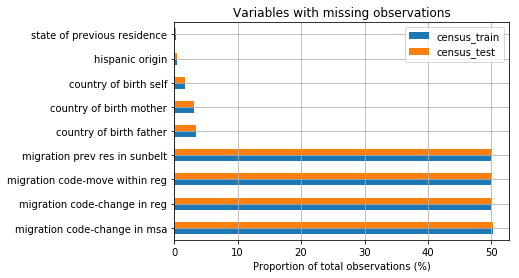

In [17]:
P = [df.isnull().sum() / len(df) for df in (census_train, census_test)]
D = DataFrame(P, index=('census_train', 'census_test')).T
D.sort_values(by='census_train', ascending=False, inplace=True)
(D[np.any(D > 0, axis=1)] * 100).plot(kind='barh', title='Variables with missing observations')
plt.xlabel('Proportion of total observations (%)')
plt.grid(True)

As observed across variables and for both training and testing data, with the exception of migration-related variables the number of missing observations is below 5%.

First, explore the relationship between continuous variables and the outcome variable, for the training dataset. This exploration is relevant to the working hypothesis that income level is related to age, capital gains, capital losses, dividends from stocks, wage per hour, weeks worked in year. Visualise the distribution of these 6 variables, in response to the outcome variable and based on kernel density estimation. (NB: Since this analysis aims primarily at subsequent classification, we disregard the feature weighting column.)

In [18]:
for df in (census_train, census_test):
    #Log-transform wage and capital-related variables
    for col in ('capital gains', 'capital losses', 'dividends from stocks', 'wage per hour'):
        df['(log) ' + col] = np.log10(df[col] + 1)

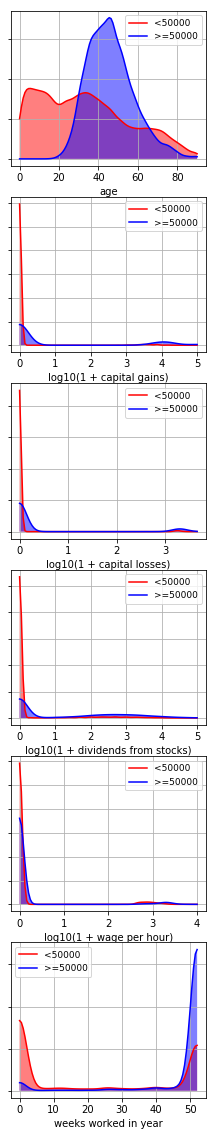

In [19]:
cols = ('age', 'capital gains', 'capital losses', 'dividends from stocks', 'wage per hour', 'weeks worked in year')
fig, axs = plt.subplots(len(cols), figsize=(3.5,20))
N_points = 100
for col, ax in zip(cols, axs):
    if col not in ('age', 'weeks worked in year'):
        data = census_train['(log) ' + col]
        xlabel = 'log10(1 + ' + col + ')'
    else:
        data = census_train[col]
        xlabel = col
    x = np.linspace(np.min(data), np.max(data), N_points)
    kde1 = scipy.stats.kde.gaussian_kde(data[census_train['salary'] == '- 50000'])
    kde2 = scipy.stats.kde.gaussian_kde(data[census_train['salary'] == '50000+'])
    y1 = kde1(x)
    y2 = kde2(x)
    y1 /= kde1.integrate_box_1d(x[0], x[-1])
    y2 /= kde2.integrate_box_1d(x[0], x[-1])    

    ax.plot(x, y1, 'r')
    ax.plot(x, y2, 'b')
    ax.fill_between(x, 0, y1, facecolor='red', alpha=0.5)
    ax.fill_between(x, 0, y2, facecolor='blue', alpha=0.5)

    ax.grid(True)    
    ax.set_xlabel(xlabel)
    for label in ax.get_yticklabels():
        label.set_visible(False)
        
    ax.legend(('<50000', '>=50000'), loc='best', prop={'size': 9})

As observed, all the aforementioned continuous variables convey information about whether an individual's earnings are in excess of 50k dollars per year. Age ranges from 0 to 90 years; very few demographic instances with age below 20 are associated with high earnings. The number of demographic instances labelled as high earners peaks at around age 45.

Among capital-related predictors (capital gains, capital losses, dividends from stocks) as well as wage per hour, earnings below 50k dollars per year are associated with low values. Values span approximately 3 to 4 orders of magnitude.

Finally, weeks worked in year exhibits strong bi-modal behaviour around the two extremes (0 weeks, 52 weeks), with the majority of demographic instances earning over 50k per year working around 50 weeks per year.

Explore the relationship between remaining (discrete) variables and the outcome variable, for the training dataset:

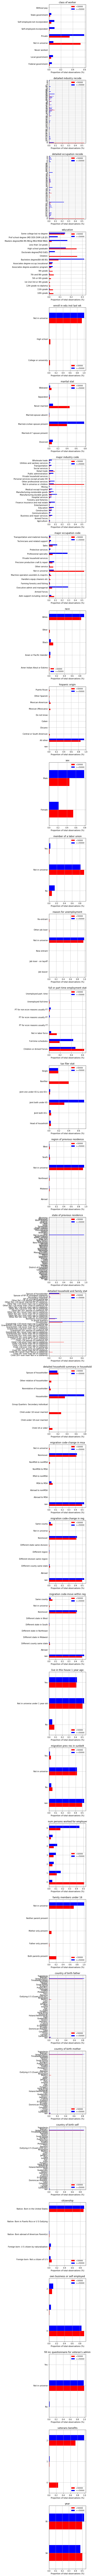

In [20]:
cols = census_train.columns
cols = [c for c in cols if c not in {'age', 'capital gains', 'capital losses', 'dividends from stocks', 'wage per hour', 'weeks worked in year', 'salary', 'instance weight'}]
cols = [c for c in cols if '(log)' not in c]

fig, axs = plt.subplots(len(cols), figsize=(3.5,250))
for col, ax in zip(cols, axs):
    data = census_train[col]
    data = [data[census_train['salary'] == '- 50000'], data[census_train['salary'] == '50000+']]
    
    counts = DataFrame([collections.Counter(d) for d in data]).fillna(0).T
    counts = counts / counts.sum()
    counts.columns = ('<50000', '>=50000')    
    
    counts.plot(kind='barh', ax=ax, color=('red', 'blue'), title=col)
    ax.legend(prop={'size': 9}, loc='best')
    ax.grid(True)
    ax.set_xlabel('Proportion of total observations (%)')

Key observations based on preceding analysis of discrete variables (in following discussion, 'likelihood' used in colloquial--rather than Bayesian--sense):
* Class of worker: The majority of demographic instances labelled as high earners appear to be for private sector workers.
* Education: Demographic instances labelled as high earners are most likely to be associated with a Bachelors or Masters degree as highest educational attainment
* Marital stat: Demographic instances labelled as high earners are most likely to be married
* Major occupation code: Demographic instances labelled as high earners are most likely to be associated with 'professional specialty' or 'executive admin and managerial' positions
* race: The proportion of demographic instances labeled 'white' is greater for high earners than for low earners, whereas the proportion of demographic instances labeled 'black' is lower for high earners than for low earners. That is, a demographic instance is more likely to be labelled 'white' if said instance is labelled a high earner, as opposed to a low earner. Conversely, a demographic instance is less likely to be labelled 'black' if said instance is labelled a high earner, as opposed to a low earner.
* Sex: A demographic instance is more likely to be labelled 'male' if said instance is labelled a high earner, as opposed to a low earner. Conversely, a demographic instance is less likely to be labelled 'female' if said instance is labelled a high earner, as opposed to a low earner.
* tax filer stat: Demographic instances labelled as high earners are most likely to fall within the 'Joint both under 65' class. The likelihood of the 'single' label appears not to change substantially if the demographic instance is labelled as high-earning as opposed to low earning.
* detailed household summary in household: Demographic instances labelled as high earners are most likely to be householders.
* citizenship: a demographic instance is more likely to be labelled 'Foreign born- US citizen by naturalisation' if said instance is labelled a high earner, as opposed to a low earner. Conversely, a demographic instance is less likely to be labelled 'Foreign born- Not a citizen of US' if said instance is labelled a high earner, as opposed to a low earner.

Next, explore the use of the variables previously examined for training a classifier. One possibile means of estimating a given variable's informativeness for predicting the binary outcome variable involves computing the Kolmogorov-Smirnov (KS) statistic between the given variable's distribution with respect to positive and negative target outcomes. *(The Kolmogorov-Smirnov statistic is the supremum of the absolute differences between the respective cumulative distributions.)*

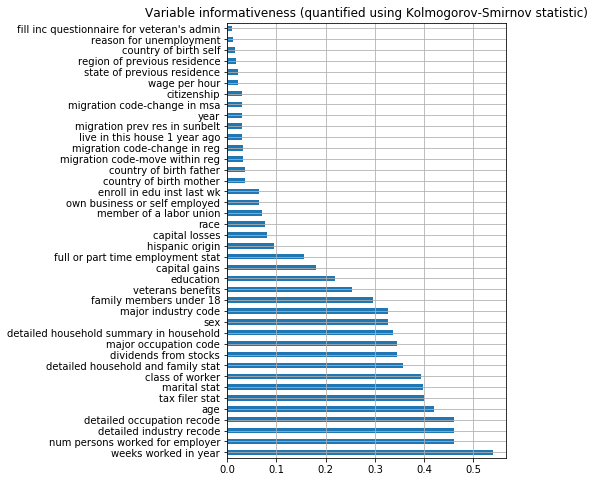

In [21]:
cols = census_train.columns
cols = [c for c in cols if '(log)' not in c and c not in ('instance weight', 'salary')]

I = census_train['salary'] == '- 50000'
test_function = lambda x, y: scipy.stats.ks_2samp(x[y], x[~y])[0]
ks_values = Series({c: test_function(census_train[c], I) for c in cols})
ks_values = ks_values.sort_values(ascending=False)
ks_values.plot(kind='barh', title='Variable informativeness (quantified using Kolmogorov-Smirnov statistic)', figsize=(5,8))
plt.grid(True)

As quantified using the KS statistic, the most important variable is 'weeks worked in year'. Among the 10 most informative variables, 5 variables appear to relate directly to occupation/occupation status, namely 'weeks worked in year', 'num persons worked for employer', 'detailed industry recode', 'detailed occupation recode', 'class of worker'. Among the 10 least informative variables, 6 variables appear to relate to migration status/geographical origin/nationality, namely 'migration prev res in sunbelt', 'migration code-change in msa', 'citizenship', 'state of previous residence', 'region of previous residence', 'country of birth self'.

Construct additional variables for classification. As a continuous variable, compute the log product of 'weeks worked in year' and 'wage per hour'. As an ordinal variable, re-encode the categories of 'education' to match the (approximate) order of attainment in the education system.

In [22]:
for df in (census_train, census_test):
    df['(log) weeks worked in year * wage per hour'] = np.log10((df['weeks worked in year'] * df['wage per hour']) + 1)
    
    mapper = {
        'Children': 0,
        'Less than 1st grade': 1,
        '1st 2nd 3rd or 4th grade': 2,
        '5th or 6th grade': 3,
        '7th and 8th grade': 4,
        '9th grade': 5,
        '10th grade': 6,
        '11th grade': 7,
        '12th grade no diploma': 8,
        'High school graduate': 9,
        'Some college but no degree': 10,
        'Associates degree-occup /vocational': 11,
        'Associates degree-academic program': 12,
        'Bachelors degree(BA AB BS)': 13,
        'Masters degree(MA MS MEng MEd MSW MBA)': 14,
        'Doctorate degree(PhD EdD)': 15,
        'Prof school degree (MD DDS DVM LLB JD)': 16 }        
    df['(ordinal) education'] = df['education'].replace(mapper)

Prepare data for classification. Replace missing data with mode of values. Represent the outcome variable using a binary indicator.

In [23]:
for df in (census_train, census_test):
    df.fillna(df.mode().iloc[0])
    df['salary'] = df['salary'] == '50000+'

Partition the training data for 10-fold cross-validation, avoiding any duplications of observations across train-test boundaries.

In [24]:
features = [c for c in census_train.columns if c not in ('instance weight', 'salary')]
n_folds = 10
np.random.seed(45)
I = np.random.permutation(len(census_train)) % n_folds

census_train = census_train.sort_values(by=features)

duplictes_all = np.where(census_train[features].duplicated(keep=False))[0]
duplicates_first = np.where(census_train[features].duplicated(keep='first'))[0]
duplicates_last = np.where(census_train[features].duplicated(keep='last'))[0]

# Determine starting locations of duplicated observations
J = np.setdiff1d(duplictes_all, duplicates_first)
# Determine finishing locations of duplicated observations
K = np.setdiff1d(duplictes_all, duplicates_last)
# Ensure that duplicated observations have consistent testing fold assignments
for i in range(len(J)):
    I[J[i]:(K[i] + 1)] = I[J[i]]

partition = I

Prepare data structure for storing trained models and predictions:

In [25]:
final_model = {'linear (basic)': {},
               'linear (full)': {},
               'random forest': {} }

As a baseline predictor, train a L2-regularised logistic regression model, based on using only continuous variables as input features. Using cross-validation and based on ROC AUC, tune the associated regularisation (hyper-)parameter, while ensuring that all input features are standardised. Subsequently determine the parameter value which yields the lowest performance still within the 95% confidence interval of the best-performing system. Fit a model using the obtained hyper-parameter value and based on all available training data.

In [805]:
def get_lo_conf_index(model):
    conf_int_lo = model.cv_results_['mean_test_score'][model.best_index_] - 1.96 * model.cv_results_['std_test_score'][model.best_index_] / np.sqrt(n_folds)
    I = np.where(model.cv_results_['mean_test_score'] > conf_int_lo)[0]
    I_min = I[np.argmin(model.cv_results_['mean_test_score'][I])]
    return I_min, conf_int_lo

In [814]:
estimators = [('scale', sklearn.preprocessing.StandardScaler()), ('clf', sklearn.linear_model.LogisticRegression(penalty='l2', n_jobs='-1', random_state=44))]
pipeline = sklearn.pipeline.Pipeline(estimators)
tuned_parameters = [{'clf__C': np.logspace(-4, -1, 10)}]
linear_model = sklearn.model_selection.GridSearchCV(pipeline, tuned_parameters, cv=sklearn.model_selection.PredefinedSplit(partition), scoring='roc_auc', verbose=2)
features = ['age', '(log) capital gains', '(log) capital losses', '(log) dividends from stocks', '(log) wage per hour', 'weeks worked in year', '(log) weeks worked in year * wage per hour']

linear_model.fit(census_train[features], census_train['salary'])

c_final = tuned_parameters[0]['clf__C'][get_lo_conf_index(linear_model)[0]]
linear_model_final = sklearn.linear_model.LogisticRegression(C=c_final, penalty='l2', n_jobs='-1', random_state=44)
linear_model_final.fit(census_train[features], census_train['salary'])

# Store final model and predictions
final_model['linear (basic)']['model'] = linear_model_final
final_model['linear (basic)']['y_hat'] = linear_model_final.predict(census_test[features])
final_model['linear (basic)']['y_hat_p'] = linear_model_final.predict_proba(census_test[features])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=   0.3s
[CV] clf__C=0.0001 ...................................................
[CV] .

[CV] .......................... clf__C=0.00464158883361, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=   0.5s
[CV] clf__C=0.01 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.2s finished


Plot the ROC AUC across considered hyper-parameter values. The dashed black line indicates best model's performance. The dashed red line indicates the lower 95% confidence bound; the solid red line indicates the worst-performing model whose performance is within the 95% confidence interval of the best model's performance.

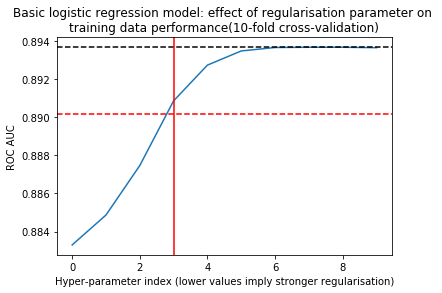

In [819]:
I_min, conf_int_lo = get_lo_conf_index(linear_model)
plt.plot(linear_model.cv_results_['mean_test_score'])
plt.title('Basic logistic regression model: effect of regularisation parameter on \ntraining data performance(10-fold cross-validation)')
plt.xlabel('Hyper-parameter index (lower values imply stronger regularisation)')
plt.ylabel('ROC AUC')
plt.axhline(linear_model.best_score_, color='k', linestyle='dashed')
plt.axhline(conf_int_lo, color='r', linestyle='dashed')
plt.axvline(I_min, color='r')

Next, train a L2-regularised logistic regression model, this time using *all available variables* (with the exception of ordinal education) as input features. Using cross-validation  and based on ROC AUC, tune the associated regularisation (hyper-)parameter, while ensuring that all input features are standardised and transforming all discrete-valued variables to dummy indicators. Subsequently determine the parameter value which yields the lowest performance still within the 95% confidence interval of the best-performing system. Fit a model using the obtained hyper-parameter value and based on all available training data.

In [828]:
estimators = [('scale', sklearn.preprocessing.StandardScaler()), ('clf', sklearn.linear_model.LogisticRegression(penalty='l2', n_jobs=-1, random_state=44))]
pipeline = sklearn.pipeline.Pipeline(estimators)
tuned_parameters = [{'clf__C': np.logspace(-4, -1, 10)}]
linear_model2 = sklearn.model_selection.GridSearchCV(pipeline, tuned_parameters, cv=sklearn.model_selection.PredefinedSplit(partition), scoring='roc_auc', verbose=2)
continuous_features = ['age', '(log) capital gains', '(log) capital losses', '(log) dividends from stocks', '(log) wage per hour', 'weeks worked in year', '(log) weeks worked in year * wage per hour']
# NB: The following includes the (ordinal) 'num persons worked for employer', but not '(ordinal) education'
discrete_features = [c for c in census_train.columns if c not in continuous_features and c not in ('instance weight', 'salary', '(ordinal) education', 'capital gains', 'capital losses', 'dividends from stocks', 'wage per hour', 'weeks worked in year')]
census_train_inc_dummies = pd.get_dummies(census_train[continuous_features + discrete_features], columns=discrete_features, sparse=False)
census_test_inc_dummies = pd.get_dummies(census_test[continuous_features + discrete_features], columns=discrete_features, sparse=False)
for c in np.setdiff1d(census_train_inc_dummies.columns, census_test_inc_dummies.columns):
    del census_train_inc_dummies[c]
for c in np.setdiff1d(census_test_inc_dummies.columns, census_train_inc_dummies.columns):
    del census_test_inc_dummies[c] 

linear_model2.fit(census_train_inc_dummies, census_train['salary'])

c_final = tuned_parameters[0]['clf__C'][get_lo_conf_index(linear_model2)[0]]
linear_model2_final = sklearn.linear_model.LogisticRegression(C=c_final, penalty='l2', n_jobs='-1', random_state=44)
linear_model2_final.fit(census_train_inc_dummies, census_train['salary'])

# Store final model and predictions
final_model['linear (full)']['model'] = linear_model2_final
final_model['linear (full)']['y_hat'] = linear_model2_final.predict(census_test_inc_dummies)
final_model['linear (full)']['y_hat_p'] = linear_model2_final.predict_proba(census_test_inc_dummies)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  17.2s
[CV] clf__C=0.0001 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s


[CV] .................................... clf__C=0.0001, total=  18.6s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  17.5s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  17.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  20.3s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  19.0s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  17.4s
[CV] clf__C=0.0001 ...................................................
[CV] .................................... clf__C=0.0001, total=  19.0s
[CV] clf__C=0.0001 ...................................................
[CV] .

[CV] .......................... clf__C=0.00464158883361, total=  47.5s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=  51.4s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=  52.6s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=  54.7s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total= 1.1min
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=  51.7s
[CV] clf__C=0.01 .....................................................
[CV] ...................................... clf__C=0.01, total=  57.4s
[CV] clf__C=0.01 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 88.3min finished


For the full regression model, analogously plot the ROC AUC across considered hyper-parameter values:

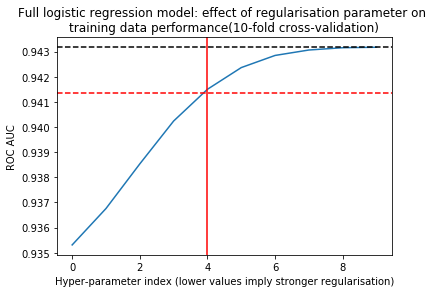

In [829]:
I_min, conf_int_lo = get_lo_conf_index(linear_model2)
plt.plot(linear_model2.cv_results_['mean_test_score'])
plt.title('Full logistic regression model: effect of regularisation parameter on \ntraining data performance(10-fold cross-validation)')
plt.xlabel('Hyper-parameter index (lower values imply stronger regularisation)')
plt.ylabel('ROC AUC')
plt.axhline(linear_model2.best_score_, color='k', linestyle='dashed')
plt.axhline(conf_int_lo, color='r', linestyle='dashed')
plt.axvline(I_min, color='r')

Finally, train a random forest classifier, this time using *all available variables* (also including ordinal education) as input features. Using cross-validation and based on ROC AUC, tune the associated forest size (hyper-)parameter. Subsequently determine the parameter value which yields the lowest performance still within the 95% confidence interval of the best-performing system. Fit a model using the obtained hyper-parameter value and based on all available training data.

In [830]:
estimators = [('scale', sklearn.preprocessing.StandardScaler()), ('clf', sklearn.ensemble.RandomForestClassifier(criterion='gini', max_features='auto', bootstrap=True, oob_score=False, n_jobs=-1, random_state=44))]
pipeline = sklearn.pipeline.Pipeline(estimators)
tuned_parameters = [{'clf__n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}]
randomforest = sklearn.model_selection.GridSearchCV(pipeline, tuned_parameters, cv=sklearn.model_selection.PredefinedSplit(partition), scoring='roc_auc', verbose=2)
# Log transformation not required
continuous_features = ['age', '(log) capital gains', '(log) capital losses', '(log) dividends from stocks', '(log) wage per hour', 'weeks worked in year', '(log) weeks worked in year * wage per hour']
# NB: The following includes the (ordinal) 'num persons worked for employer', but not '(ordinal) education'
discrete_features = [c for c in census_train.columns if c not in continuous_features and c not in ('instance weight', 'salary', '(ordinal) education', 'capital gains', 'capital losses', 'dividends from stocks', 'wage per hour', 'weeks worked in year')]
# Include '(ordinal) education'
census_train_inc_dummies = pd.get_dummies(census_train[continuous_features + discrete_features + ['(ordinal) education']], columns=discrete_features, sparse=False)
census_test_inc_dummies = pd.get_dummies(census_test[continuous_features + discrete_features + ['(ordinal) education']], columns=discrete_features, sparse=False)
for c in np.setdiff1d(census_train_inc_dummies.columns, census_test_inc_dummies.columns):
    del census_train_inc_dummies[c]
for c in np.setdiff1d(census_test_inc_dummies.columns, census_train_inc_dummies.columns):
    del census_test_inc_dummies[c]

randomforest.fit(census_train_inc_dummies, census_train['salary'])

n_estimators_final = tuned_parameters[0]['clf__n_estimators'][get_lo_conf_index(randomforest)[0]]
randomforest_final = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators_final, criterion='gini', max_features='auto', bootstrap=True, oob_score=False, n_jobs=-1, random_state=44)
randomforest_final.fit(census_train_inc_dummies, census_train['salary'])

# Store final model and predictions
final_model['random forest']['model'] = randomforest_final
final_model['random forest']['y_hat'] = randomforest_final.predict(census_test_inc_dummies)
final_model['random forest']['y_hat_p'] = randomforest_final.predict_proba(census_test_inc_dummies)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   6.3s
[CV] clf__n_estimators=20 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s remaining:    0.0s


[CV] ............................. clf__n_estimators=20, total=   6.7s
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   6.4s
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   6.7s
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   6.1s
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   6.1s
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   7.1s
[CV] clf__n_estimators=20 ............................................
[CV] ............................. clf__n_estimators=20, total=   6.6s
[CV] clf__n_estimators=20 ............................................
[CV] .

[CV] ............................ clf__n_estimators=120, total=  25.9s
[CV] clf__n_estimators=140 ...........................................
[CV] ............................ clf__n_estimators=140, total=  31.4s
[CV] clf__n_estimators=140 ...........................................
[CV] ............................ clf__n_estimators=140, total=  29.9s
[CV] clf__n_estimators=140 ...........................................
[CV] ............................ clf__n_estimators=140, total=  30.2s
[CV] clf__n_estimators=140 ...........................................
[CV] ............................ clf__n_estimators=140, total=  29.9s
[CV] clf__n_estimators=140 ...........................................
[CV] ............................ clf__n_estimators=140, total=  30.2s
[CV] clf__n_estimators=140 ...........................................
[CV] ............................ clf__n_estimators=140, total=  29.3s
[CV] clf__n_estimators=140 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 45.6min finished


For the random forest, analogously plot the ROC AUC across considered hyper-parameter values:

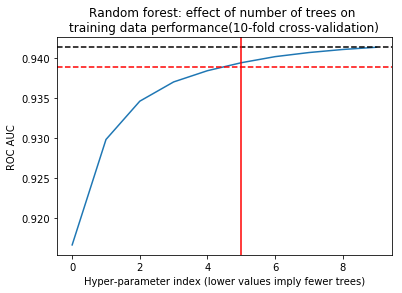

In [833]:
I_min, conf_int_lo = get_lo_conf_index(randomforest)
plt.plot(randomforest.cv_results_['mean_test_score'])
plt.title('Random forest: effect of number of trees on \ntraining data performance(10-fold cross-validation)')
plt.xlabel('Hyper-parameter index (lower values imply fewer trees)')
plt.ylabel('ROC AUC')
plt.axhline(randomforest.best_score_, color='k', linestyle='dashed')
plt.axhline(conf_int_lo, color='r', linestyle='dashed')
plt.axvline(I_min, color='r')

Compare perfomance of obtained models against testing dataset. To help evaluate the two models' performance with respect to the testing data, define a bootstrap sampling function for estimating standard errors:

In [834]:
def bootstrap_statistic(stat_function, y_test, y_hat):
    #Setting random seed ensures paired samples
    np.random.seed(3743)
    N = 10**3
    result = np.empty(N)
    for n in xrange(N):
        I = np.random.choice(len(y_test), len(y_test))
        result[n] = stat_function(y_test[I], y_hat[I])
        
    return result

Based on the testing data, for the three models compute accuracy, precision, recall, and ROC AUC statistics, along with standard errors:

In [835]:
y_test = census_test['salary']

for model in final_model.keys():
    print("-------------Model %s-------------" % model)        
        
    y_hat = final_model[model]['y_hat']
    
    for statistic_fun, message in zip((sklearn.metrics.accuracy_score, sklearn.metrics.precision_score, sklearn.metrics.recall_score), ('Accuracy', 'Precision', 'Recall')):
        statistic = statistic_fun(y_test, y_hat)
        statistic_bootstrap = bootstrap_statistic(statistic_fun, y_test, y_hat)    
        print(message + ": \t%.3f +- SE %.3f" % (statistic, np.std(statistic_bootstrap)))
    
    y_hat_p = final_model[model]['y_hat_p'][:,1]
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_hat_p)
    roc_auc_bootstrap = bootstrap_statistic(sklearn.metrics.roc_auc_score, y_test, y_hat_p)    
    print("ROC AUC: \t%.3f +- SE %.3f" % (roc_auc, np.std(roc_auc_bootstrap)))

-------------Model linear (full)-------------
Accuracy: 	0.950 +- SE 0.001
Precision: 	0.727 +- SE 0.009
Recall: 	0.312 +- SE 0.006
ROC AUC: 	0.940 +- SE 0.001
-------------Model random forest-------------
Accuracy: 	0.954 +- SE 0.001
Precision: 	0.724 +- SE 0.008
Recall: 	0.405 +- SE 0.006
ROC AUC: 	0.940 +- SE 0.002
-------------Model linear (basic)-------------
Accuracy: 	0.942 +- SE 0.001
Precision: 	0.691 +- SE 0.014
Recall: 	0.113 +- SE 0.004
ROC AUC: 	0.845 +- SE 0.002


Key observations and conclusions:
* Both full logistic regression model and random forest yield similar results, with approximately 95% accuracy, 94% ROC AUC.
* The basic logistic regression model yields lower performance, nonetheless its reliance on few features results suggest that we may predict a subset of high earners using a combination of relatively few predictors.

With a view to obtaining insight about the profiles of high-earners, one possible supervised approach involves decision tree learning. This approach offers the potential for obtaining straightforward classification rules to decide whether a given demographic instance is a high earner. On the other hand, possible drawbacks of the approach are the propensity for overfitting in decision trees; moreover classification rules are required to be consise in order to be readily interpreted.

As devised, a decision tree is constructed using the provided training data, with the positive instances re-sampled to attain class balance. To promote rule parsimony and to avoid overfitting, we control the maximum depth (i.e. the maximum rule length) as a hyperparameter, with chosen values between 1 and 20. Similarly, we tolerate a node impurity of 0.01 when training.

Having constructed a decision tree, using the testing data we compute the precision and recall for each individual classification rule in the decision tree. Subsequently, we report those classification rules which yield both high precision and recall, in terms of the F1 score. Used in conjunction with decision tree rules, precision and recall offer the advantage of being readily interpretable by end users, e.g. "if rule x is fulfilled, there is an n% chance of the demographic instance being a high earner, with m% of high earners covered by rule x".

In [873]:
# Using un-transformed features not necessary, but helps interpretability
continuous_features = ['age', 'capital gains', 'capital losses', 'dividends from stocks', 'wage per hour', 'weeks worked in year', '(log) weeks worked in year * wage per hour']
# NB: The following doesn't include the (ordinal) 'num persons worked for employer', or '(ordinal) education'
categorical_features = [c for c in census_train.columns if c not in continuous_features and '(log)' not in c and c not in ('(ordinal) education', 'education', 'num persons worked for employer', 'salary', 'instance weight')]
ordinal_features = ['num persons worked for employer', '(ordinal) education']
census_train_inc_dummies = pd.get_dummies(census_train[continuous_features + categorical_features + ordinal_features], columns=categorical_features, sparse=False)
census_test_inc_dummies = pd.get_dummies(census_test[continuous_features + categorical_features + ordinal_features], columns=categorical_features, sparse=False)
for c in np.setdiff1d(census_train_inc_dummies.columns, census_test_inc_dummies.columns):
    del census_train_inc_dummies[c]
for c in np.setdiff1d(census_test_inc_dummies.columns, census_train_inc_dummies.columns):
    del census_test_inc_dummies[c]

# Over-sample positive training instances to ensure balanced classes
I = np.where(census_train['salary'] == True)[0]
J = np.where(census_train['salary'] == False)[0]
I = np.append(J, np.random.choice(I, len(J), replace=True))
np.random.shuffle(I)
    
max_depth = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
decisiontree = {}
for m in max_depth:
    print("Building tree with maximum depth %d..." % m)
    decisiontree[m] = sklearn.tree.DecisionTreeClassifier(criterion='gini', random_state=45, max_depth=m, min_impurity_split=0.01)
    decisiontree[m].fit(census_train_inc_dummies.iloc[I], census_train.iloc[I]['salary'])

Building tree with maximum depth 1...
Building tree with maximum depth 2...
Building tree with maximum depth 4...
Building tree with maximum depth 6...
Building tree with maximum depth 8...
Building tree with maximum depth 10...
Building tree with maximum depth 12...
Building tree with maximum depth 14...
Building tree with maximum depth 16...
Building tree with maximum depth 18...
Building tree with maximum depth 20...


Next, using unseen testing data, determine for each decision tree how frequently each path contained in the tree is used to predict the target variable. Compute statistics and for each tree order classification rules by their F1 score.

In [874]:
path_freqs = {}
for m in max_depth:
    print("Obtaining path frequencies for tree with maximum depth %d..." % m)
    
    decision_paths = {v: decisiontree[m].decision_path(census_test_inc_dummies[census_test['salary'] == v])
                      for v in (0, 1)}
    path_freqs[m] = {v: collections.Counter() for v in (0, 1)}
    for v in (0, 1):
        for i in xrange(decision_paths[v].shape[0]):
            node_ids = np.where(np.squeeze(np.asarray(decision_paths[v].getrow(i).todense())))[0]
            path_freqs[m][v][tuple(node_ids)] += 1
        path_freqs[m][v] = DataFrame([path_freqs[m][v].keys(), path_freqs[m][v].values()]).T
        path_freqs[m][v].columns = ['path', 'count_salary=' + str(v)]

    path_freqs[m] = path_freqs[m][0].merge(path_freqs[m][1], on='path', how='outer')
    path_freqs[m].fillna(0, inplace=True)
    
    path_freqs[m]['rule length'] = path_freqs[m]['path'].apply(lambda t: len(t) - 1)
    path_freqs[m]['precision'] = path_freqs[m]['count_salary=1'] / (path_freqs[m]['count_salary=1'] + path_freqs[m]['count_salary=0'])
    path_freqs[m]['recall'] = path_freqs[m]['count_salary=1'] / path_freqs[m]['count_salary=1'].sum()
    path_freqs[m]['F1 score'] = 2 * ((path_freqs[m]['precision'] * path_freqs[m]['recall']) / (path_freqs[m]['precision'] + path_freqs[m]['recall']))
    path_freqs[m].sort_values(by='F1 score', ascending=False, inplace=True)
    path_freqs[m]['recall (cumulative)'] = path_freqs[m]['recall'].cumsum()
    path_freqs[m].reset_index(inplace=True)

Obtaining path frequencies for tree with maximum depth 1...
Obtaining path frequencies for tree with maximum depth 2...
Obtaining path frequencies for tree with maximum depth 4...
Obtaining path frequencies for tree with maximum depth 6...
Obtaining path frequencies for tree with maximum depth 8...
Obtaining path frequencies for tree with maximum depth 10...
Obtaining path frequencies for tree with maximum depth 12...
Obtaining path frequencies for tree with maximum depth 14...
Obtaining path frequencies for tree with maximum depth 16...
Obtaining path frequencies for tree with maximum depth 18...
Obtaining path frequencies for tree with maximum depth 20...


To optimise the hyper-parameter value (i.e. maximum depth / maximum rule lenth), for each obtained decision tree select a subset of (F1 score-ordered) classification rules such that the subset has a cumulative recall exceeding 0.33. (We require that the rules explain 1/3 of all demographic instances labelled as high earners). For each rule subset, plot the average precision and recall, the size of the rule subset and the average rule length.

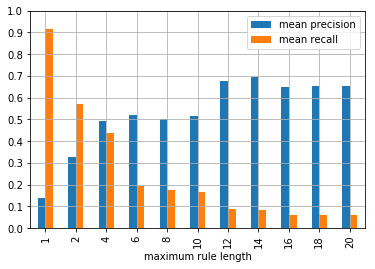

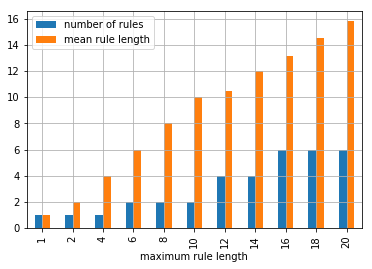

In [875]:
required_recall = 0.33
n_rules_required = {m: (path_freqs[m]['recall (cumulative)'] < required_recall).sum() + 1 for m in max_depth}
mean_stats = [path_freqs[m].iloc[:n_rules_required[m]][['precision', 'recall', 'rule length']].mean() for m in max_depth]
mean_stats = DataFrame(mean_stats, index=max_depth)
mean_stats = mean_stats.add_prefix('mean ')
mean_stats['number of rules'] = Series(n_rules_required)
mean_stats.index.name = 'maximum rule length'

mean_stats[['mean precision', 'mean recall']].plot(kind='bar', grid=True)
plt.yticks(np.linspace(0, 1, 11))
mean_stats[['number of rules', 'mean rule length']].plot(kind='bar', grid=True)
#plt.yticks(np.linspace(0, 20, 11))

As observed, increasing the maximum rule length from 10 to 12 yields a substantial increase in mean precision exceeding 0.70, with mean precision remaining approximately constant for larger values. With 4 corresponding classification rules, proceed to analyse the decisions contained in the rule set for maximum rule length 12:

In [878]:
chosen_max_depth = 12
chosen_rules = path_freqs[chosen_max_depth][:n_rules_required[chosen_max_depth]]['path']
path_freqs[chosen_max_depth][:n_rules_required[chosen_max_depth]][['rule length', 'precision', 'recall', 'F1 score', 'recall (cumulative)']]

,rule length,precision,recall,F1 score,recall (cumulative)
0,12,0.454985,0.151956,0.227824,0.151956
1,12,0.564718,0.087456,0.151456,0.239412
2,12,0.720654,0.078403,0.141420,0.317814
3,6,0.970711,0.037504,0.072218,0.355318


Print the above subset of classification rules for decision tree with maximum depth 12:

In [879]:
for (i, rule) in enumerate(chosen_rules):
    perf = np.array(path_freqs[chosen_max_depth].iloc[i][['precision', 'recall']])
    print("Classification rule %d (Precision=%.2f, Recall=%.2f):" % (i, perf[0], perf[1]))
    for node, nextnode in zip(rule[:-1], rule[1:]):
        feat = decisiontree[chosen_max_depth].tree_.feature[node]
        feat = census_test_inc_dummies.columns[feat]
        thresh = decisiontree[chosen_max_depth].tree_.threshold[node]
        if nextnode == decisiontree[chosen_max_depth].tree_.children_left[node]:
            comp_op = '<='
        else:
            comp_op = '>'
        print("\t%s %s %d" % (feat, comp_op, thresh))

Classification rule 0 (Precision=0.45, Recall=0.15):
	weeks worked in year > 39
	(ordinal) education > 12
	age > 28
	sex_Male > 0
	dividends from stocks <= 0
	marital stat_Never married <= 0
	capital gains <= 7364
	major occupation code_Other service <= 0
	major occupation code_Adm support including clerical <= 0
	major occupation code_Transportation and material moving <= 0
	detailed occupation recode_10 <= 0
	detailed occupation recode_12 <= 0
Classification rule 1 (Precision=0.56, Recall=0.09):
	weeks worked in year > 39
	(ordinal) education > 12
	age > 28
	sex_Male > 0
	dividends from stocks > 0
	capital gains <= 9953
	detailed occupation recode_44 <= 0
	detailed occupation recode_39 <= 0
	detailed occupation recode_41 <= 0
	detailed occupation recode_10 <= 0
	(ordinal) education <= 13
	country of birth mother_Philippines <= 0
Classification rule 2 (Precision=0.72, Recall=0.08):
	weeks worked in year > 39
	(ordinal) education > 12
	age > 28
	sex_Male > 0
	dividends from stocks > 0


As observed, all 4 extracted classification rules rely on the following 4 basic characteristics being fulfilled:

* weeks worked in year > 36
* education > 12 (as per our encoding, this means a Bachelors degree, Masters degree, Doctorate, Prof school degree)
* age > 28
* sex is Male

The individual classification rule refine the above basic rule as follows:

* Rule 0: No dividends from stocks; never married; capital gains <= 7364; does not work in "Other service", "Adm support including clerical" or "Transportation and material moving", or occupation re-codes 10 or 12.
* Rule 1: Has dividends from stocks and capital gains <= 9953, does not have occupation re-codes 44, 39, 41 or 10, not educated beyond Bachelors degree, mother's country of birth is not the Philippines
* Rule 2: Has dividends from stocks and capital gains <= 9953, does not have occupation re-codes 44, 39, 41 or 10, or 12, educated beyond Bachelors degree
* Rule 3: Has dividends from stocks and capital gains > 9953

We further observe that a precision of 0.45 represents an approximate 7-fold increase in the precision obtained without incorporating any predictors (i.e. based on predicting the minority class):

In [883]:
0.45 / census_test['salary'].sum() * len(census_test['salary'])

7.257177497575169

Conclusion
---
This analysis involved predicting the income category for demographic instances reported in US census data. The analysis involved exploration of predictor variables, training and evaluating 3 alternative classifiers, as well as supervised segmentation of demographic instances based on evaluating decision tree classification rules. Classification results match those reported in the dataset metadata for boosted trees. Supervised segmentation of demographic instances yields 4 straightforward classification rules for predicting 33% of positive testing instances with average precision 68%.

Apparent from the described analyis, the segmentation of demographic instances is a challenging problem. Whereas the chosen approach is both straightforward and readily interpretable, it is unclear whether is satisfies the requirement of intentifying disparate groups of high-income demographic instances, as opposed to largely homogenous groups (as suggested by the decisions common to the 4 classification rules). To remedy the potential issue of homogenous demographic groups, one possible refinement might consist of first applying unsupervised clustering to the positive training instances, then building decision tree for classifying only those instances in each identified cluster.